### Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

### Holt-Winters

Triple Exponential Smoothing, also known as the Holt-Winters method, is one of the many methods or algorithms that can be used to forecast data points in a series, provided that the series is “seasonal”, i.e. repetitive over some period.

In [2]:
series = [3,10,12,13,12,10,12]

In [3]:
def average(series):
    return float(sum(series))/len(series)

# Given the above series, the average is:
average(series)

10.285714285714286

In [4]:
# moving average using n last points
def moving_average(series, n):
    return average(series[-n:])

moving_average(series, 3)
moving_average(series, 4)

11.333333333333334

11.75

A moving average can actually be quite effective, especially if you pick the right n for the series. Stock analysts adore it.

In [44]:
# weighted average, weights is a list of weights
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weights = [0.1, 0.2, 0.3, 0.4]
weighted_average(series, weights)

11.500000000000002

In [45]:
# given a series and alpha, return series of smoothed points
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

exponential_smoothing(series, 0.1)
exponential_smoothing(series, 0.9)


[3, 3.7, 4.53, 5.377, 6.0393, 6.43537, 6.991833]

[3, 9.3, 11.73, 12.873000000000001, 12.0873, 10.20873, 11.820873]

In [7]:
df = pd.DataFrame({
    'x': list(range(len(series)+1)),
    'average': [*series, average(series)],
    'moving average 4': [*series, moving_average(series, 4)],
    'moving average 3': [*series, moving_average(series, 3)],
    'weighted average': [*series, weighted_average(series, weights)],
    'single exponential smoothing 0.9': [*exponential_smoothing(series, 0.9), moving_average(exponential_smoothing(series, 0.9), 3)],
    'single exponential smoothing 0.5': [*exponential_smoothing(series, 0.5), moving_average(exponential_smoothing(series, 0.5), 3)],
})

<Figure size 1080x1080 with 0 Axes>

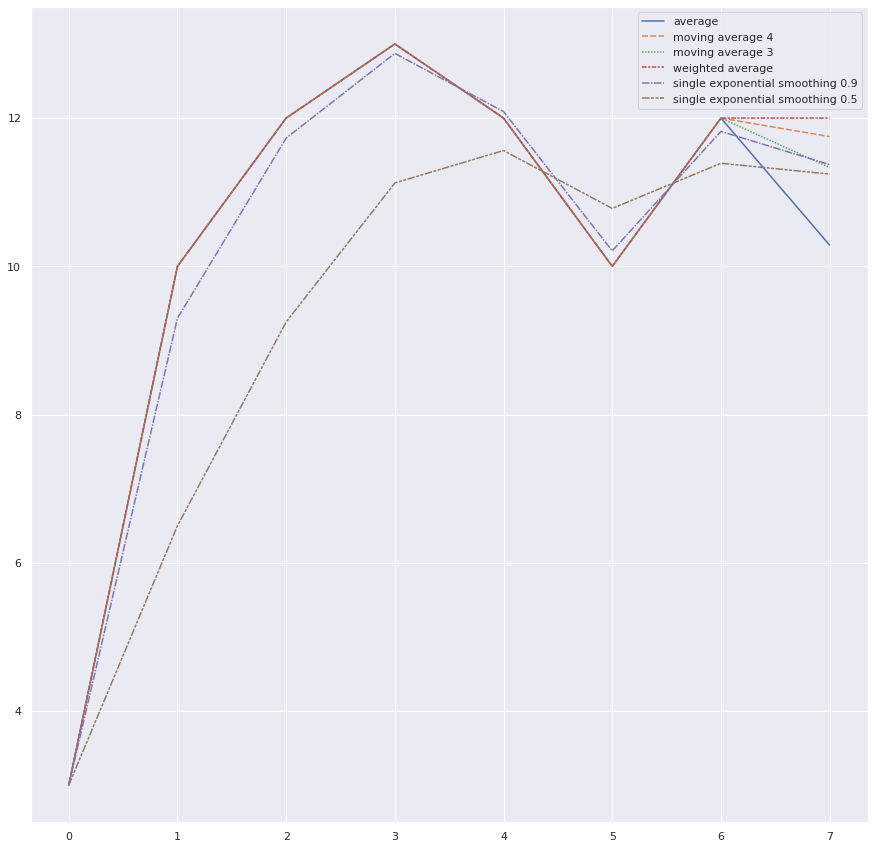

In [8]:
plt.figure(figsize=(15,15))
sns.lineplot(data=df)

In [9]:
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

double_exponential_smoothing(series, alpha=0.9, beta=0.9)

[3,
 17.0,
 15.45,
 14.210500000000001,
 11.396044999999999,
 8.183803049999998,
 12.753698384500002,
 13.889016464000003]

<Figure size 1080x1080 with 0 Axes>

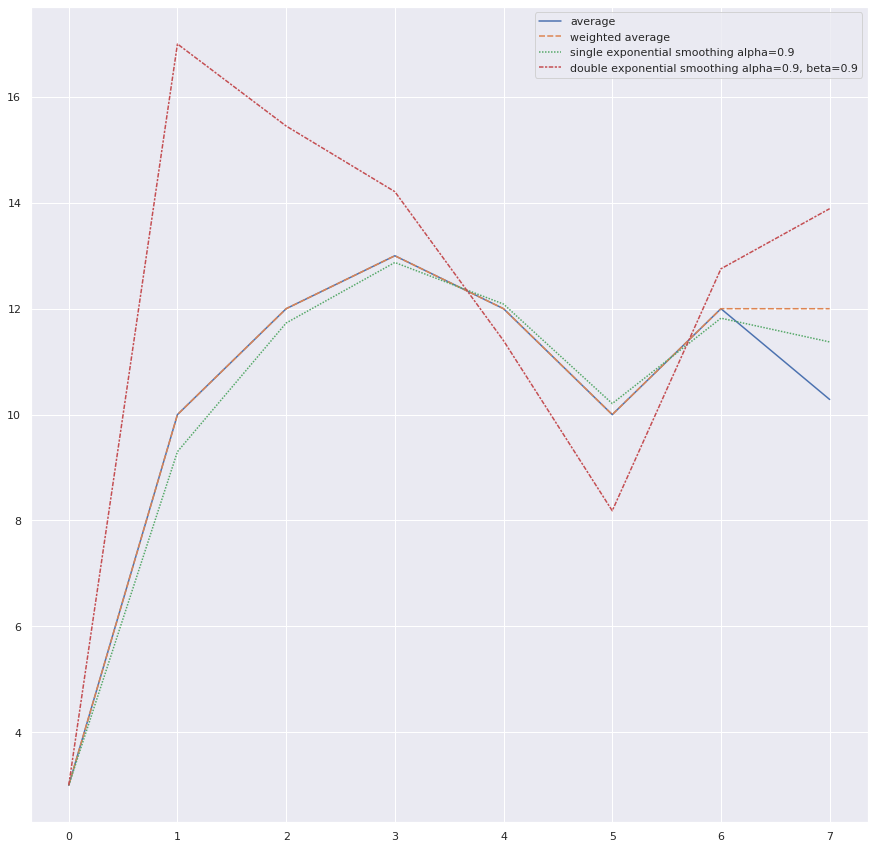

In [10]:
df_exp = pd.DataFrame({
    "average": df.average,
    "weighted average": df["weighted average"],
    "single exponential smoothing alpha=0.9": df["single exponential smoothing 0.9"],
    "double exponential smoothing alpha=0.9, beta=0.9": double_exponential_smoothing(series, alpha=0.9, beta=0.9)
})
plt.figure(figsize=(15,15))
sns.lineplot(data=df_exp)

In [11]:
longer_series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

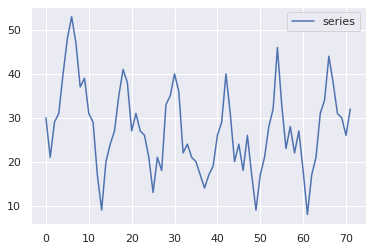

In [12]:
_df = pd.DataFrame({"series": longer_series})
sns.lineplot(data=_df)

In [13]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

initial_trend(longer_series, 12)

-0.7847222222222222

In [14]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

initial_seasonal_components(longer_series, 12)

{0: -7.4305555555555545,
 1: -15.097222222222221,
 2: -7.263888888888888,
 3: -5.097222222222222,
 4: 3.402777777777778,
 5: 8.069444444444445,
 6: 16.569444444444446,
 7: 9.736111111111112,
 8: -0.7638888888888887,
 9: 1.902777777777778,
 10: -3.263888888888889,
 11: -0.7638888888888887}

In [15]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# forecast 24 points (i.e. two seasons)
forecast = triple_exponential_smoothing(longer_series, 12, alpha=0.716, beta=0.029, gamma=0.993, n_preds=24)
len(forecast)

96

<Figure size 1080x360 with 0 Axes>

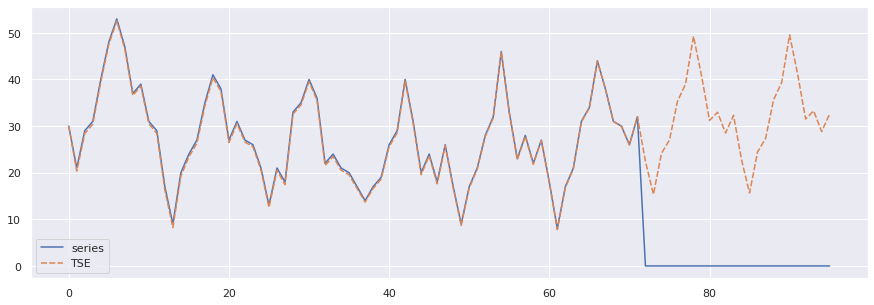

In [16]:
_df = pd.DataFrame({"series": [*longer_series, *[0]*24],
                    "TSE": forecast
                   })
plt.figure(figsize=(15,5))
sns.lineplot(data=_df)

### simple Holt-Winters example:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
# df = pd.read_csv('/home/ayhan/international-airline-passengers.csv', 
#                  parse_dates=['Month'], 
#                  index_col='Month'
# )
# df.index.freq = 'MS'
# train, test = df.iloc[:130, 0], df.iloc[130:, 0]

In [19]:
longer_series = pd.Series(longer_series)

In [20]:
train, test = longer_series[:50], longer_series[50:]

In [21]:
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

<Figure size 1080x720 with 0 Axes>

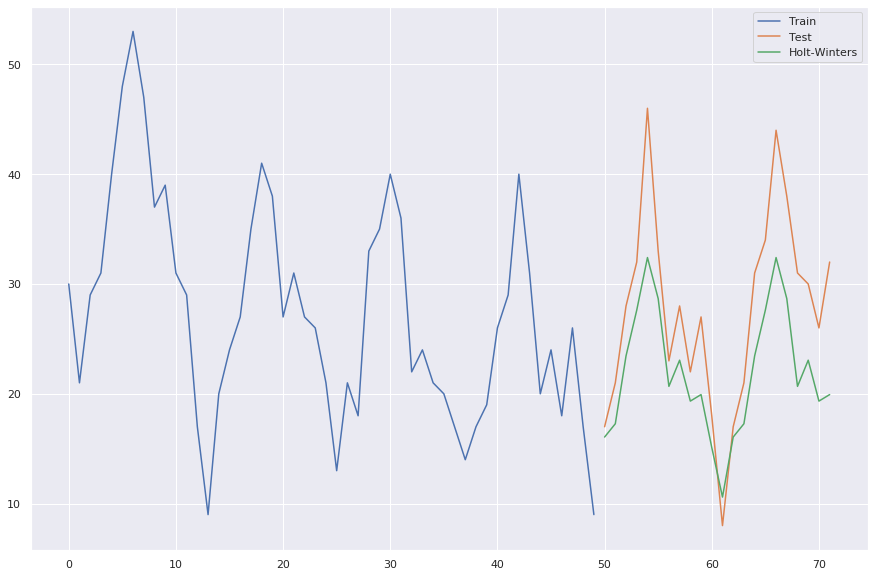

In [46]:
plt.figure(figsize=(15,10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

## on some datasets: Milk dataset

In [27]:
import os
dataset_milk_path = os.path.expanduser("~/projects/data_mining/monthly-milk-production-pounds-p.csv")

In [28]:
df_milk = pd.read_csv(dataset_milk_path, 
                 parse_dates=['Month'], 
                 index_col='Month')
df_milk.head()

,Pounds
Month,
1962-01-01,578.3
1962-02-01,609.8
1962-03-01,628.4
1962-04-01,665.6
1962-05-01,713.8


In [29]:
from sklearn.model_selection import train_test_split

milk_train, milk_test = train_test_split(df_milk, test_size=0.2, shuffle=False)

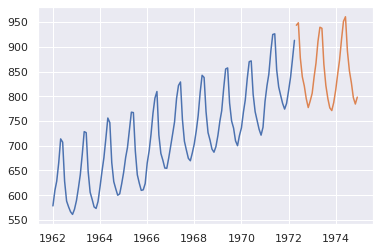

In [30]:
plt.plot(milk_train.index, milk_train, label='train')
plt.plot(milk_test.index, milk_test, label='test')

In [31]:
milk_model = ExponentialSmoothing(milk_train.Pounds, seasonal='mul', seasonal_periods=12).fit()

In [32]:
milk_pred = milk_model.predict(start=milk_test.index[0], end=milk_test.index[-1])

<Figure size 1080x720 with 0 Axes>

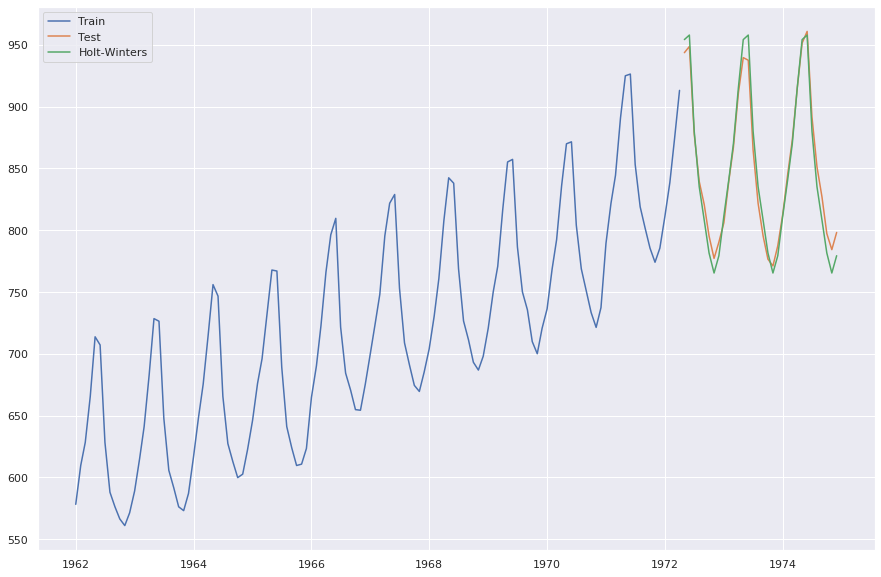

In [33]:
plt.figure(figsize=(15,10))
plt.plot(milk_train.index, milk_train, label='Train')
plt.plot(milk_test.index, milk_test, label='Test')
plt.plot(milk_pred.index, milk_pred, label='Holt-Winters')
plt.legend(loc='best')

In [34]:
rms_milk = sqrt(mean_squared_error(milk_test, milk_pred))
rms_milk

11.11682228642366

## on some datasets: 

In [35]:
dataset_sales_path = os.path.expanduser("~/projects/data_mining/monthly-sales-for-a-souvenir-sho.csv")

In [36]:
df_sales = pd.read_csv(dataset_sales_path, 
                 parse_dates=['Month'], 
                 index_col='Month')
df_sales.head()

,Sales
Month,
1987-01-01,1664.81
1987-02-01,2397.53
1987-03-01,2840.71
1987-04-01,3547.29
1987-05-01,3752.96


In [37]:
sales_train, sales_test = train_test_split(df_sales, test_size=0.2, shuffle=False)

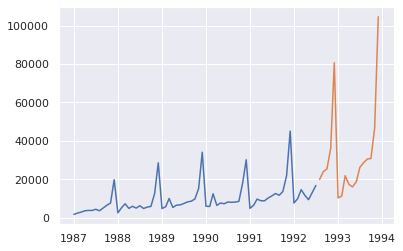

In [38]:
plt.plot(sales_train.index, sales_train, label='train')
plt.plot(sales_test.index, sales_test, label='test')

In [39]:
sales_model = ExponentialSmoothing(sales_train.Sales, seasonal='mul', seasonal_periods=12).fit()

In [40]:
sales_pred = sales_model.predict(start=sales_test.index[0], end=sales_test.index[-1])

<Figure size 1080x720 with 0 Axes>

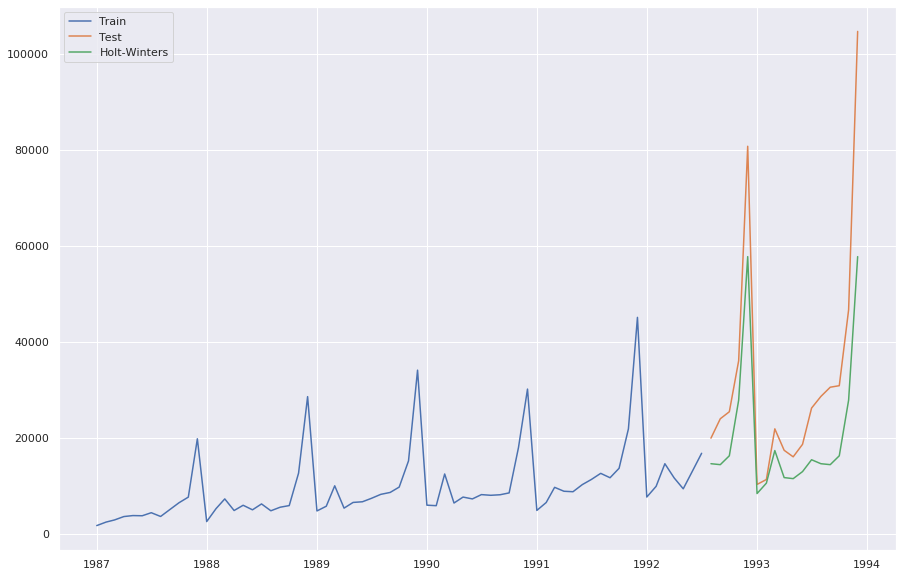

In [41]:
plt.figure(figsize=(15,10))
plt.plot(sales_train.index, sales_train, label='Train')
plt.plot(sales_test.index, sales_test, label='Test')
plt.plot(sales_pred.index, sales_pred, label='Holt-Winters')
plt.legend(loc='best')

In [42]:
rms_sales = sqrt(mean_squared_error(sales_test, sales_pred))
rms_sales

15820.653881157126

## on dataset: JohnsonJohnson

,x
1,0.71
2,0.63
3,0.85
4,0.44
5,0.61


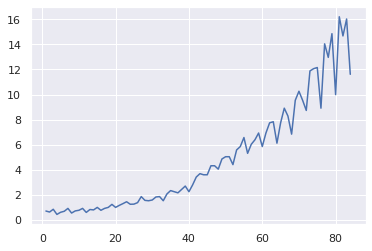

In [48]:
dataset_john_path = os.path.expanduser("~/projects/data_mining/JohnsonJohnson.csv")
df_john = pd.read_csv(dataset_john_path, index_col=0)
df_john.head()
plt.plot(df_john.index, df_john, label='train')
df_john["x"] = [2, *np.diff(np.log(df_john.x))+2]

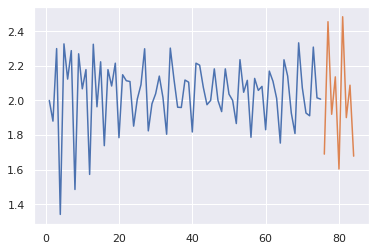

In [49]:
john_train, john_test = train_test_split(df_john, test_size=0.1, shuffle=False)
plt.plot(john_train.index, john_train, label='train')
plt.plot(john_test.index, john_test, label='test')

In [59]:
john_model = ExponentialSmoothing(john_train.x, seasonal='mul', seasonal_periods=4).fit()
john_pred = john_model.predict(start=john_test.index[0], end=john_test.index[-1])

<Figure size 1080x720 with 0 Axes>

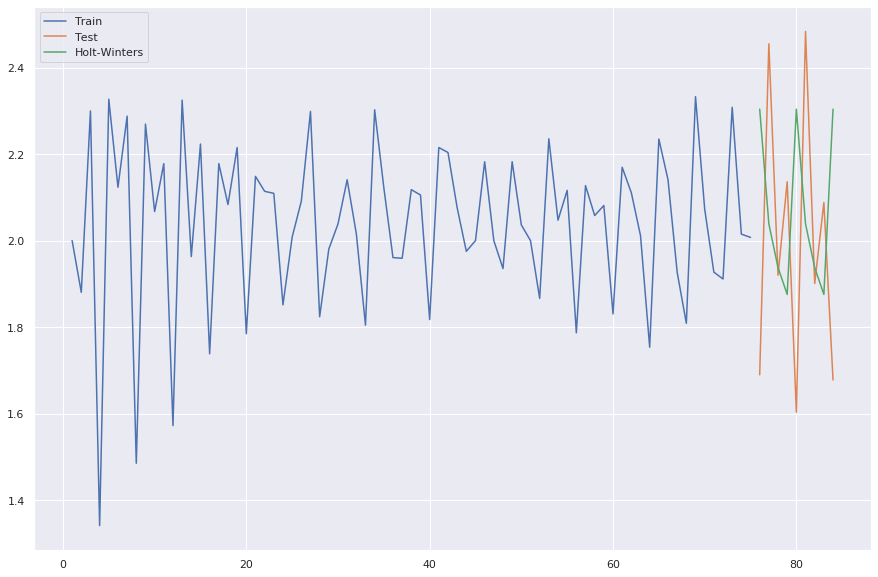

In [60]:
plt.figure(figsize=(15,10))
plt.plot(john_train.index, john_train, label='Train')
plt.plot(john_test.index, john_test, label='Test')
plt.plot(john_pred.index, john_pred, label='Holt-Winters')
plt.legend(loc='best')

## wiki:

In [64]:
wiki_path = os.path.expanduser("~/projects/data_mining/wiki.csv")
df_wiki = pd.read_csv(wiki_path, usecols=["x"])
df_wiki.head()

,x
0,148672476
1,149593840
2,141164198
3,145612937
4,151495372


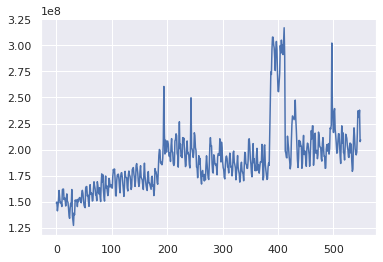

In [65]:
plt.plot(df_wiki.index, df_wiki, label='train')
# df_wiki["x"] = [2, *np.diff(np.log(df_john.x))+2]

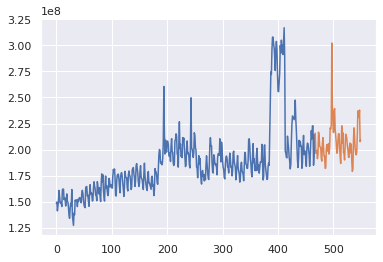

In [66]:
wiki_train, wiki_test = train_test_split(df_wiki, test_size=0.15, shuffle=False)
plt.plot(wiki_train.index, wiki_train, label='train')
plt.plot(wiki_test.index, wiki_test, label='test')

In [67]:
wiki_test.head()

,x
467,215744159
468,196584962
469,197214704
470,199247266
471,191223582


In [68]:
wiki_model = ExponentialSmoothing(wiki_train.x, seasonal='mul', seasonal_periods=100).fit()
wiki_pred = wiki_model.predict(start=wiki_test.index[0], end=wiki_test.index[-1])

<Figure size 1440x720 with 0 Axes>

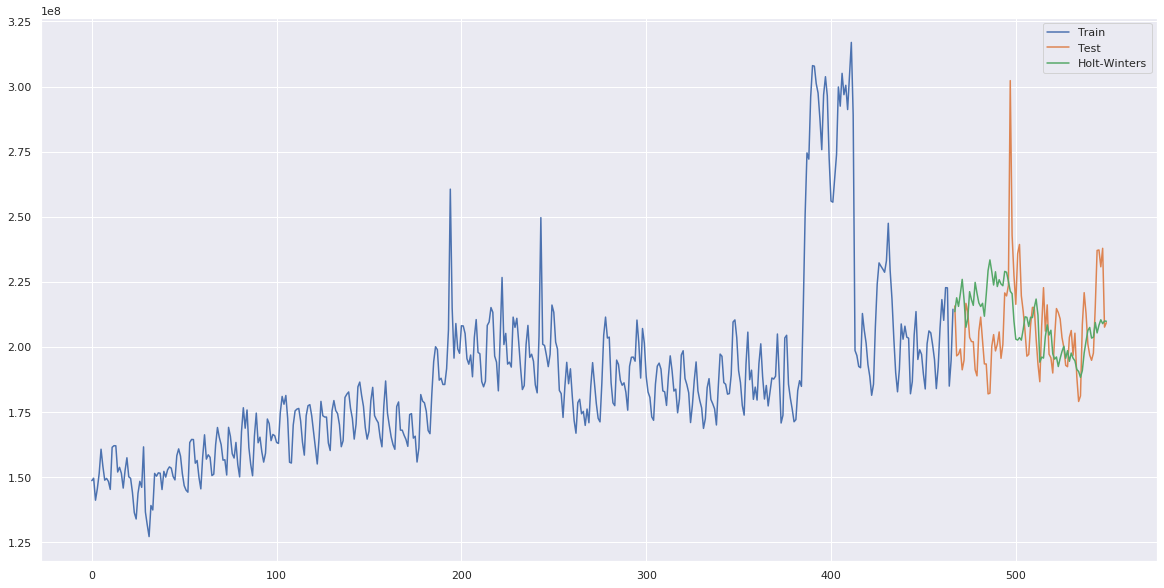

In [69]:
plt.figure(figsize=(20,10))
plt.plot(wiki_train.index, wiki_train, label='Train')
plt.plot(wiki_test.index, wiki_test, label='Test')
plt.plot(wiki_pred.index, wiki_pred, label='Holt-Winters')
plt.legend(loc='best')

In [70]:
rms = sqrt(mean_squared_error(wiki_test, wiki_pred))
rms

20580715.456674572

## predicting Bitcoin

In [294]:
bc_path = os.path.expanduser("~/projects/data_mining/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09_filled.csv")

In [298]:
df_bc = pd.read_csv(bc_path, index_col="Timestamp")
df_bc.head(2)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0


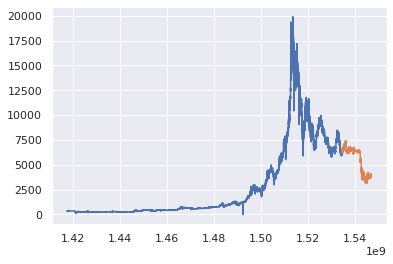

In [303]:
df_bc = df_bc[["Weighted_Price"]]
bc_train, bc_test = train_test_split(df_bc, test_size=0.1, shuffle=False)
plt.plot(bc_train.index, bc_train, label='train')
plt.plot(bc_test.index,bc_test, label='test')

In [305]:
bc_model = ExponentialSmoothing(bc_train["Weighted_Price"], seasonal='mul', seasonal_periods=12).fit()
bc_pred = bc_model.predict(start=bc_test.index[0], end=bc_test.index[-1])

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(bc_train.index, bc_train, label='Train')
plt.plot(bc_test.index, bc_test, label='Test')
plt.plot(bc_pred.index, bc_pred, label='Holt-Winters')
plt.legend(loc='best')